In [45]:
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, hamming_loss, classification_report
from mlxtend.plotting import plot_decision_regions 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
meme_df = pd.read_csv('data/meme_coins_20.csv')
stable_df = pd.read_csv('data/stable_coins_20.csv')

In [6]:
meme_df['Class'] = 0
stable_df['Class'] = 1

In [7]:
df = pd.concat((meme_df, stable_df), axis=0)

In [8]:
df.head(5)

,name,symbol,price,market cap,24h volume,24h,7d,30d,Class
0,Dogecoin,DOGE,$0.1882,$28.60B,$1.81B,6.24%,1.48%,-32.43%,0
1,Shiba Inu,SHIB,$0.000009911,$5.85B,$107.10M,6.19%,-0.50%,-26.02%,0
2,MemeCore,M,$1.90,$3.21B,$10.86M,-1.87%,-15.84%,-25.07%,0
3,Pepe (pepe.vip),PEPE,$0.000006750,$2.80B,$373.36M,6.14%,0.32%,-41.03%,0
4,Pudgy Penguins,PENGU,$0.02146,$1.48B,$170.86M,7.01%,-1.26%,-43.60%,0


In [9]:
df.tail(5)

,name,symbol,price,market cap,24h volume,24h,7d,30d,Class
15,Usual,USD0,$0.9983,$547.24M,$1.02M,-0.00%,-0.01%,0.01%,1
16,USDD,USDD,$0.9998,$498.27M,$1.03M,-0.01%,-0.01%,-0.16%,1
17,Ondo US Dollar Yield Token,USDY,$1.11,$437.70M,$2.34K,0.03%,-0.09%,0.26%,1
18,USDJ,USDJ,$1.21,$331.34M,$3.07M,-0.51%,-1.24%,-8.44%,1
19,EURC,EURC,$1.16,$261.77M,$47.06M,-0.65%,1.47%,-1.28%,1


In [10]:
df.drop(['name'], axis=1, inplace=True)

In [11]:
df.head()

,symbol,price,market cap,24h volume,24h,7d,30d,Class
0,DOGE,$0.1882,$28.60B,$1.81B,6.24%,1.48%,-32.43%,0
1,SHIB,$0.000009911,$5.85B,$107.10M,6.19%,-0.50%,-26.02%,0
2,M,$1.90,$3.21B,$10.86M,-1.87%,-15.84%,-25.07%,0
3,PEPE,$0.000006750,$2.80B,$373.36M,6.14%,0.32%,-41.03%,0
4,PENGU,$0.02146,$1.48B,$170.86M,7.01%,-1.26%,-43.60%,0


In [12]:
def parse_abbreviated_number(value):
    if pd.isna(value):
        return value
    
    value = str(value).strip().replace('$', '').replace(',', '')
    
    multipliers = {
        'K': 10**3, 'M': 10**6, 'B': 10**9, 'T': 10**12
    }
    
    if value[-1].upper() in multipliers:
        number = float(value[:-1])
        multiplier = value[-1].upper()
        return number * multipliers[multiplier]
    else:
        return float(value)

In [13]:
df_pca = df.drop(['symbol'], axis=1)
df_pca = df_pca.drop(['Class'], axis=1)
for col in df_pca.columns:
    if df_pca[col].dtype == 'object':
        df_pca[col] = df[col].astype(str).apply(lambda x: re.sub(r'[^\d.-]', '', x))
df_pca['24h'] = df_pca['24h'].map(lambda x: abs(float(x)))
df_pca['7d'] = df_pca['7d'].map(lambda x: abs(float(x)))
df_pca['30d'] = df_pca['30d'].map(lambda x: abs(float(x)))

In [14]:
df_pca.head()

,price,market cap,24h volume,24h,7d,30d
0,0.1882,28.60,1.81,6.24,1.48,32.43
1,0.000009911,5.85,107.10,6.19,0.50,26.02
2,1.90,3.21,10.86,1.87,15.84,25.07
3,0.000006750,2.80,373.36,6.14,0.32,41.03
4,0.02146,1.48,170.86,7.01,1.26,43.60


In [15]:
standard_scaler = StandardScaler()
df_pca = standard_scaler.fit_transform(df_pca)

In [16]:
pca = PCA()
pca_result = pca.fit_transform(df_pca)

In [17]:
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df['symbol'] = df['symbol'].values

In [18]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,symbol
0,0.784509,-0.324619,-0.515292,0.882646,-0.674626,0.153518,DOGE
1,0.487957,-0.734777,-0.759849,0.408401,-0.584519,0.291510,SHIB
2,0.195248,-0.283483,1.733419,0.557927,-0.306452,-1.067854,M
3,0.459417,-1.907106,-1.180917,0.173349,0.645683,0.097818,PEPE
4,0.951551,-1.189871,-0.905555,0.759282,0.020492,0.109773,PENGU


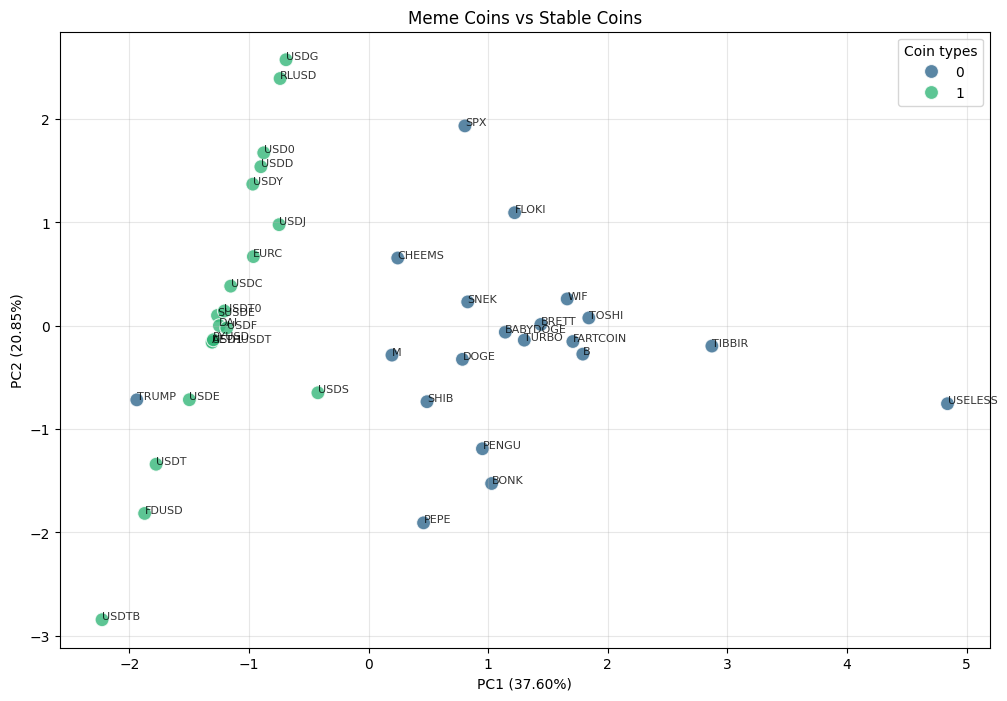

In [19]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
X = pca_df[['PC1', 'PC2']]
y = df['Class']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<Axes: >

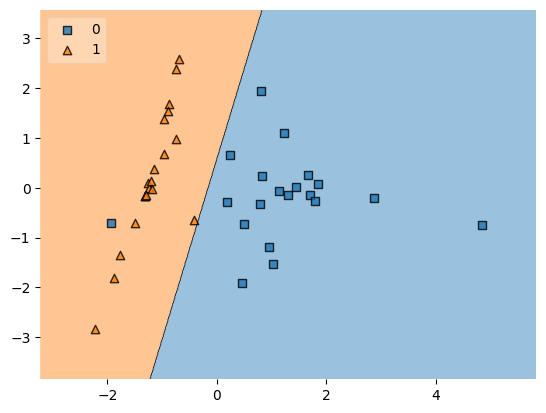

In [23]:
plot_decision_regions(X.to_numpy(), y.to_numpy(), clf=logistic_regression, legend=2)  

In [24]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


<Axes: >

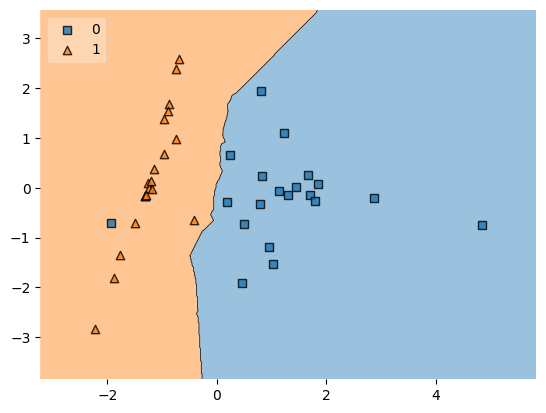

In [25]:
plot_decision_regions(X.to_numpy(), y.to_numpy(), clf=knn, legend=2)  

In [26]:
nearest_centroid = NearestCentroid()
nearest_centroid.fit(X_train, y_train)

,metric,'euclidean'
,shrink_threshold,None
,priors,'uniform'


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NearestCentroid was fitted with feature names
  warnings.warn(


<Axes: >

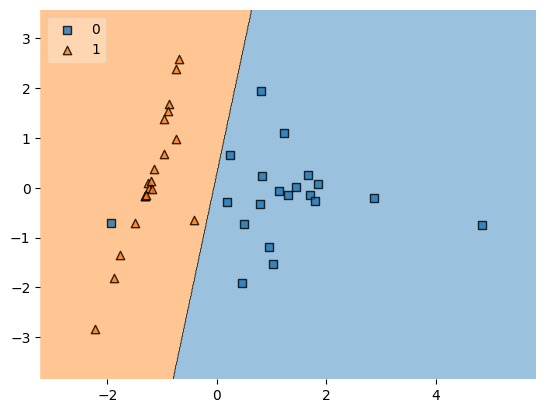

In [27]:
plot_decision_regions(X.to_numpy(), y.to_numpy(), clf=nearest_centroid, legend=2)  

In [28]:
svc_linear = SVC(kernel='linear')
svc_linear.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


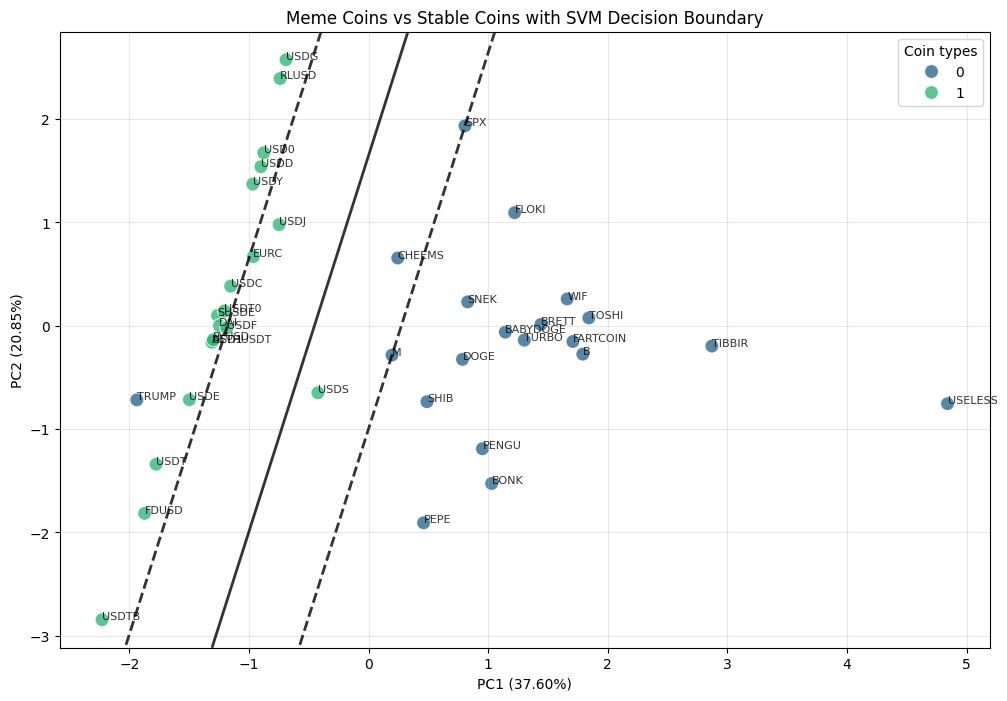

/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


<Axes: >

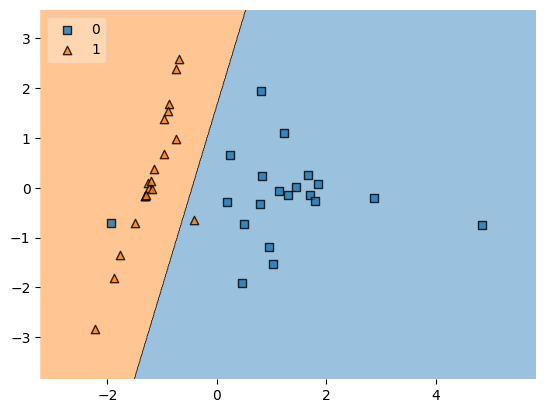

In [29]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = svc_linear.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8, 
           linestyles=['--', '-', '--'], linewidths=2)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins with SVM Decision Boundary')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

plot_decision_regions(X.to_numpy(), y.to_numpy(), clf=svc_linear, legend=2)  

In [30]:
svc_poly = SVC(C=10, kernel='poly')
svc_poly.fit(X_train, y_train)

,C,10
,kernel,'poly'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


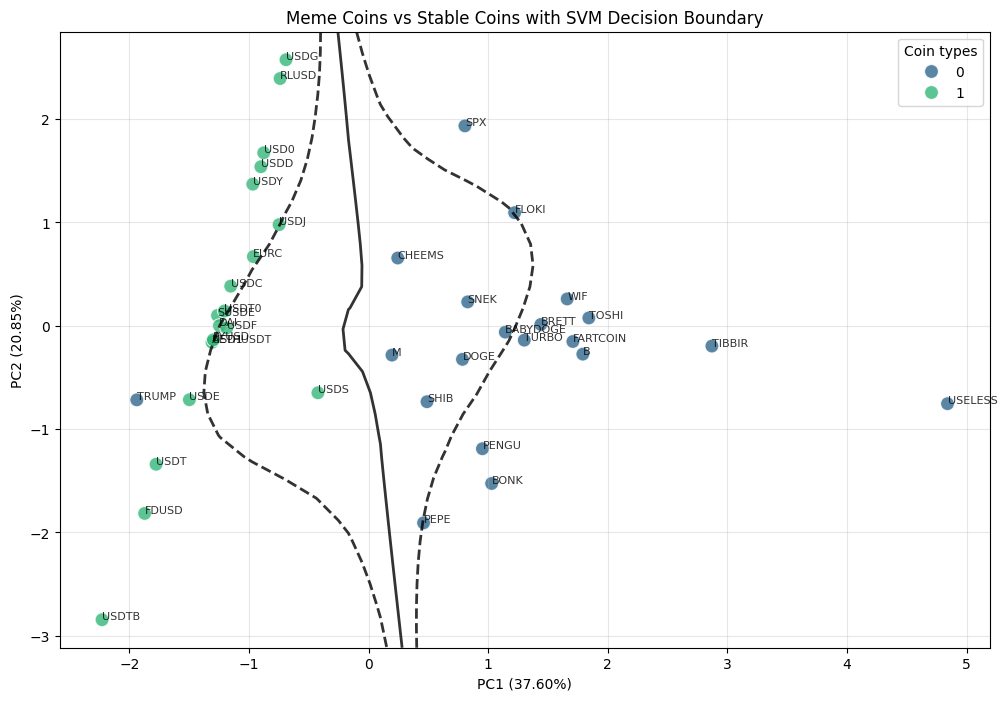

/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


<Axes: >

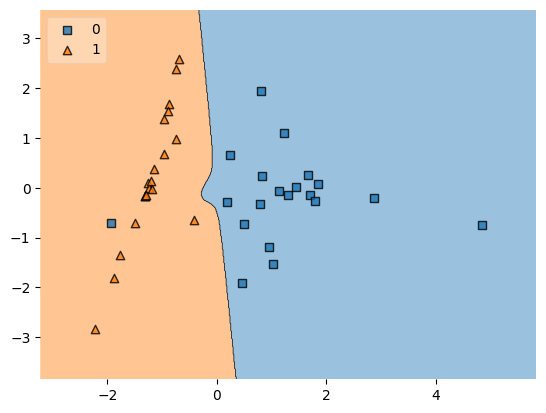

In [31]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = svc_poly.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8, 
           linestyles=['--', '-', '--'], linewidths=2)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins with SVM Decision Boundary')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

plot_decision_regions(X.to_numpy(), y.to_numpy(), clf=svc_poly, legend=2)  

In [32]:
svc_rbf = SVC(C=10, kernel='rbf')
svc_rbf.fit(X_train, y_train)

,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


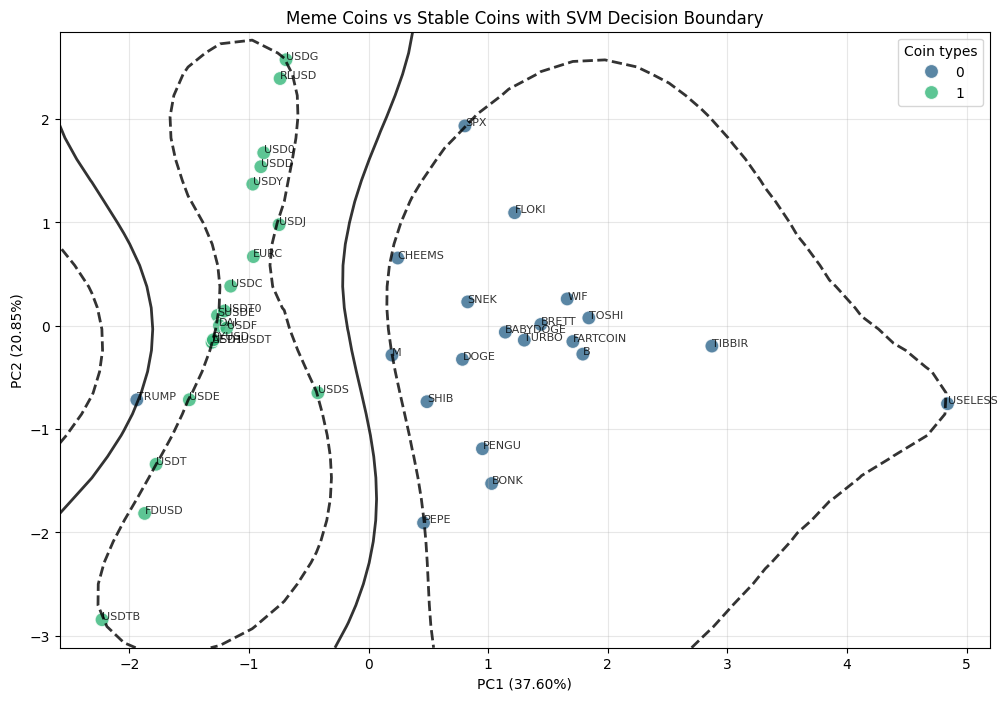

/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


<Axes: >

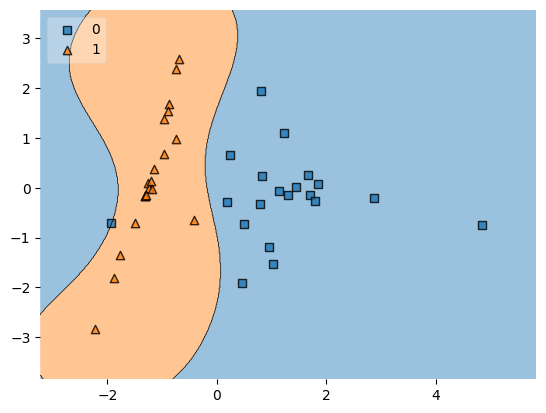

In [33]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = svc_rbf.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8, 
           linestyles=['--', '-', '--'], linewidths=2)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins with SVM Decision Boundary')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

plot_decision_regions(X.to_numpy(), y.to_numpy(), clf=svc_rbf, legend=2)  

In [34]:
svc_sigmoid = SVC(kernel='sigmoid')
svc_sigmoid.fit(X_train, y_train)

,C,1.0
,kernel,'sigmoid'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


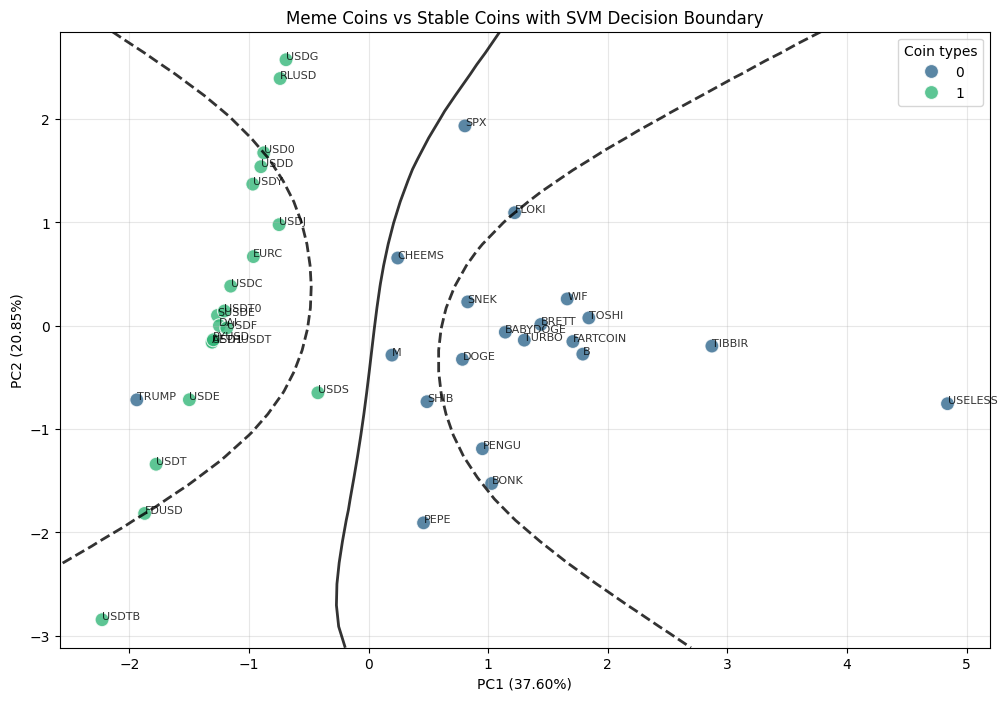

/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


<Axes: >

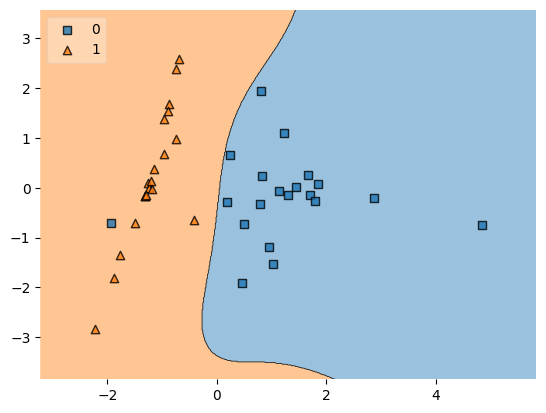

In [35]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = svc_sigmoid.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8, 
           linestyles=['--', '-', '--'], linewidths=2)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins with SVM Decision Boundary')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

plot_decision_regions(X.to_numpy(), y.to_numpy(), clf=svc_sigmoid, legend=2)  

In [36]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


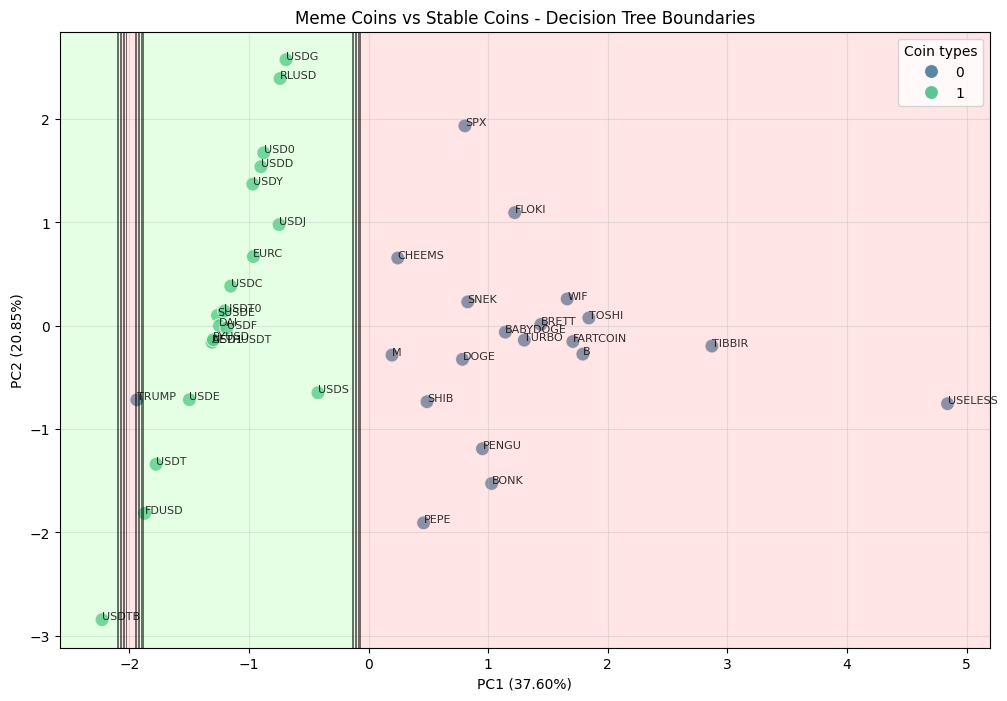

/Users/ps/Documents/GitHub/aiqf-cyrpto/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Axes: >

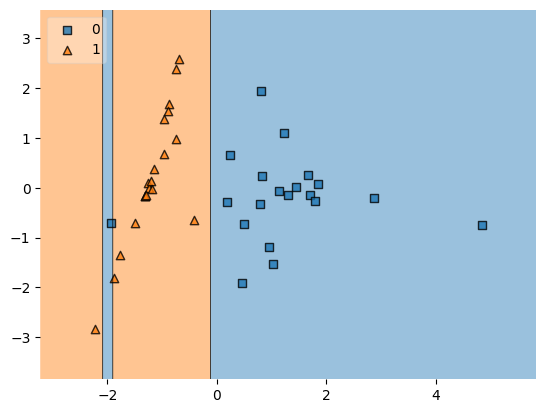

In [37]:
plt.figure(figsize=(12, 8))

plot_df = pca_df[['PC1', 'PC2', 'symbol']].copy()
plot_df['Class'] = df['Class'].values

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Class', 
                palette='viridis', s=100, alpha=0.8)

for i, row in plot_df.iterrows():
    plt.annotate(row['symbol'], (row['PC1'], row['PC2']), 
                fontsize=8, alpha=0.8)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 100)
yy = np.linspace(ylim[0], ylim[1], 100)
XX, YY = np.meshgrid(xx, yy)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = tree.predict(xy)
Z = Z.reshape(XX.shape)

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ['#FF0000', '#00FF00']
plt.contourf(XX, YY, Z, alpha=0.3, cmap=cmap_light)
plt.contour(XX, YY, Z, colors='k', linewidths=0.5, alpha=0.8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title('Meme Coins vs Stable Coins - Decision Tree Boundaries')
plt.legend(title='Coin types')
plt.grid(True, alpha=0.3)
plt.show()

plot_decision_regions(X.to_numpy(), y.to_numpy(), clf=tree, legend=2)  

In [38]:
trials = 10

logistic_regression_accuracy = 0
knn_accuracy = 0
nearest_centroid_accuracy = 0
svc_linear_accuracy = 0
svc_poly_accuracy = 0
svc_rbf_accuracy = 0
svc_sigmoid_accuracy = 0
tree_accuracy = 0

logistic_regression_y_pred = 0
knn_y_pred = 0
nearest_centroid_y_pred = 0
svc_linear_y_pred = 0
svc_poly_y_pred = 0
svc_rbf_y_pred = 0
svc_sigmoid_y_pred = 0
tree_y_pred = 0

accuracies = [
    logistic_regression_accuracy,
    knn_accuracy,
    nearest_centroid_accuracy,
    svc_linear_accuracy,
    svc_poly_accuracy,
    svc_rbf_accuracy,
    svc_sigmoid_accuracy,
    tree_accuracy
]

predictions = [
    logistic_regression_y_pred,
    knn_y_pred,
    nearest_centroid_y_pred,
    svc_linear_y_pred,
    svc_poly_y_pred,
    svc_rbf_y_pred,
    svc_sigmoid_y_pred,
    tree_y_pred
]

models = [
    logistic_regression,
    knn,
    nearest_centroid,
    svc_linear,
    svc_poly,
    svc_rbf,
    svc_sigmoid,
    tree
]

for i in range(trials):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    for i in range(len(models)):
        models[i].fit(X_train, y_train)
        predictions[i] = models[i].predict(X_test)
        accuracies[i] += accuracy_score(y_test, predictions[i], normalize=True)

for i in range(len(accuracies)):
    accuracies[i] *= (100 / trials)

In [39]:
print(f"Accuracy of logistic regression: {accuracies[0]}%")
print(f"Accuracy of KNN: {accuracies[1]}%")
print(f"Accuracy of nearest centroid: {accuracies[2]}%")
print(f"Accuracy of linear SVC: {accuracies[3]}%")
print(f"Accuracy of polynomial SVC: {accuracies[4]}%")
print(f"Accuracy of RBF SVC: {accuracies[5]}%")
print(f"Accuracy of sigmoid SVC: {accuracies[6]}%")
print(f"Accuracy of decision trees: {accuracies[7]}%")

Accuracy of logistic regression: 95.0%
Accuracy of KNN: 98.0%
Accuracy of nearest centroid: 99.0%
Accuracy of linear SVC: 94.0%
Accuracy of polynomial SVC: 93.0%
Accuracy of RBF SVC: 94.0%
Accuracy of sigmoid SVC: 95.0%
Accuracy of decision trees: 94.0%


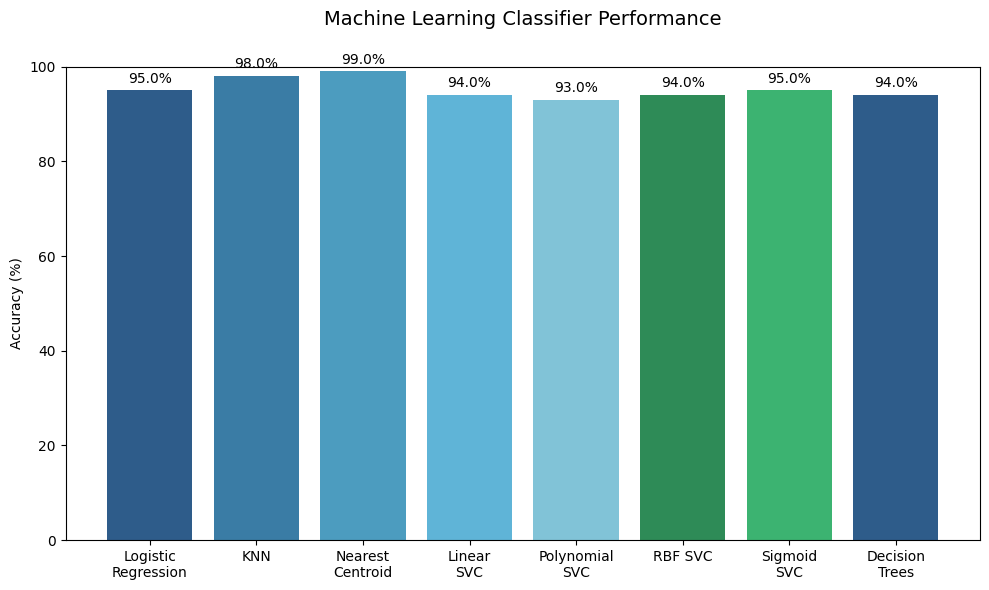

In [40]:
classifiers = ['Logistic\nRegression', 'KNN', 'Nearest\nCentroid', 'Linear\nSVC', 'Polynomial\nSVC', 
               'RBF SVC', 'Sigmoid\nSVC', 'Decision\nTrees']

plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, accuracies, color = ['#2E5C8A', '#3A7CA5', '#4C9CBF', '#5FB4D7', '#81C3D7', 
                '#2E8B57', '#3CB371'])

plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Machine Learning Classifier Performance', pad=30, fontsize=14)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [43]:
def namestr(obj, namespace=globals()):
    return [name for name in namespace if namespace[name] is obj]

In [46]:
for i in range(len(models)):
    print(f"{namestr(models[i])} Classification Results:\n")
    print(f"Hamming Loss: {hamming_loss(y_test, predictions[i]):.3f}")
    print("\nClassification Report per label:")
    print(classification_report(y_test, predictions[i]) + "\n")

['logistic_regression', '_22'] Classification Results:

Hamming Loss: 0.000

Classification Report per label:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


['knn', '_24'] Classification Results:

Hamming Loss: 0.000

Classification Report per label:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10


['nearest_centroid', '_26'] Classification Results:

Hamming Loss: 0.000

Classification Report per label:
              precision    recall